In [522]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing modulus**

In [523]:
!pip install lazypredict

In [524]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler


# **Defining some Functions**

In [525]:
def train_model(model, param_grid, x_train, y_train, x_test, y_test, scoring = 'f1'):
  # Crie o objeto GridSearchCV

  grid_search = GridSearchCV(model, param_grid, cv=5, scoring = scoring, n_jobs=-1)

  # Ajuste o modelo aos dados

  grid_search.fit(x_train, y_train)

  # Imprima os melhores parâmetros encontrados
  print("Melhores Parâmetros:", grid_search.best_params_)

  # Imprima a melhor pontuação encontrada durante a busca
  best = grid_search.best_score_
  print("Melhor métrica", best)


  y_pred_train = grid_search.predict(X_train)
  y_pred_test = grid_search.predict(X_test)

  ac_tre = accuracy_score(y_pred_train, y_train)
  ac_tes = accuracy_score(y_pred_test, y_test)
  print("Acurácea nos Dados de Treinamento:", ac_tre)
  print("Acurácea nos Dados de Teste:", ac_tes)

  # Imprima o relatório de classificação
  print("Relatório de Classificação Treinamento:")
  print(classification_report(y_pred_train, y_train))

  print("Relatório de Classificação Teste:")
  print(classification_report(y_pred_test, y_test))

  return ac_tre, ac_tes, best,  grid_search

In [526]:
def AUC_ROC(model, X, y_test):
  y_pred_dt_test = model.predict(X)
  ROCAUCscore = roc_auc_score(y_test, y_pred_dt_test)
  print(f"AUC-ROC for model with tuned hyperparameters: {ROCAUCscore:.4f}")

In [527]:
def replace_outliers(arr, method='both', threshold=2.0):
    if method == 'mean':
        mean_val = np.mean(arr)
        std_dev = np.std(arr)
        outliers = (arr - mean_val) > threshold * std_dev
        arr[outliers] = mean_val

    elif method == 'median':
        median_val = np.median(arr)
        mad = np.median(np.abs(arr - median_val))
        outliers = (arr - median_val) > threshold * mad
        arr[outliers] = median_val

    elif method == 'both':
        # Replace outliers using both mean and median methods
        arr_mean = arr.copy()
        arr_median = arr.copy()

        mean_val = np.mean(arr)
        std_dev = np.std(arr)
        outliers_mean = (arr - mean_val) > threshold * std_dev
        arr_mean[outliers_mean] = mean_val

        median_val = np.median(arr)
        mad = np.median(np.abs(arr - median_val))
        outliers_median = (arr - median_val) > threshold * mad
        arr_median[outliers_median] = median_val

        # Choose the method with lower mean absolute deviation
        mad_mean = np.mean(np.abs(arr - arr_mean))
        mad_median = np.mean(np.abs(arr - arr_median))

        if mad_mean < mad_median:
            arr = arr_mean
        else:
            arr = arr_median

    return arr

# **Getting data**

In [528]:
df0 = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/titanic.zip (Unzipped Files)/train.csv')

In [529]:
df00 = df0.copy(deep=True)

In [530]:
target0 = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/titanic.zip (Unzipped Files)/test.csv')

# **Pre_processing data**

In [531]:
df00.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [532]:
drop_list1 = ['PassengerId', 'Cabin', 'Name', 'Ticket']
'''drop_list1 = ['PassengerId',
 'Name',
 'Age',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']'''

"drop_list1 = ['PassengerId',\n 'Name',\n 'Age',\n 'Ticket',\n 'Fare',\n 'Cabin',\n 'Embarked']"

In [533]:
df0.drop(['Survived'], axis=1, inplace=True)
df0.drop(drop_list1, axis=1, inplace=True)

In [534]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [535]:
index = target0['PassengerId']
target0.drop(drop_list1, axis=1, inplace=True)

In [536]:
#df0['SibSp'] = df0['SibSp'].astype('category')
#target0['SibSp'] = target0['SibSp'].astype('category')

In [537]:
for i, j in enumerate(df0['Parch'].values):
  if j <= 1:
    df0['Parch'].loc[i] = '1'

  elif j <= 2:
    df0['Parch'].loc[i] = '2'

  elif j <= 3:
    df0['Parch'].loc[i] = '3'

  elif j <= 4:
    df0['Parch'].loc[i] = '4'

  elif j > 4:
    df0['Parch'].loc[i] = '5'



In [538]:
for i, j in enumerate(target0['Parch'].values):
  if j <= 1:
    target0['Parch'].loc[i] = '1'

  elif j <= 2:
    target0['Parch'].loc[i] = '2'

  elif j <= 3:
    target0['Parch'].loc[i] = '3'

  elif j <= 4:
    target0['Parch'].loc[i] = '4'

  elif j > 4:
    target0['Parch'].loc[i] = '5'



In [539]:
df0['Parch'].value_counts()

1    796
2     80
5      6
3      5
4      4
Name: Parch, dtype: int64

In [540]:
target0['Parch'].value_counts()

1    376
2     33
5      4
3      3
4      2
Name: Parch, dtype: int64

In [541]:
df0['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [542]:
target0['Age'].value_counts()

21.00    17
24.00    17
22.00    16
30.00    15
18.00    13
         ..
76.00     1
28.50     1
22.50     1
62.00     1
38.50     1
Name: Age, Length: 79, dtype: int64

In [543]:
df0['Age'] = df0['Age'].fillna(df0['Age'].median())
df0['Embarked'] = df0['Embarked'].fillna(df0['Embarked'].mode()[0])
df0['Pclass'] = df0['Pclass'].astype('str')
df0['Parch'] = df0['Parch'].astype('str')



'''
df0['Ticket'] = df0['Ticket'].apply(lambda x: x[0:4])
df0['Ticket'] = df0['Ticket'].astype('category')
df0['Ticket'] = df0['Ticket'].cat.codes'''

target0['Age'] = target0['Age'].fillna(df0['Age'].median())
target0['Embarked'] = target0['Embarked'].fillna(target0['Embarked'].mode()[0])
target0['Fare'] = target0['Fare'].fillna(df0['Fare'].astype('float64').median())
target0['Pclass'] = target0['Pclass'].astype('str')
target0['Parch'] = target0['Parch'].astype('str')


'''
target0['Ticket'] = target0['Ticket'].apply(lambda x: x[0:4])
target0['Ticket'] = target0['Ticket'].astype('category')
target0['Ticket'] = target0['Ticket'].cat.codes'''


"\ntarget0['Ticket'] = target0['Ticket'].apply(lambda x: x[0:4])\ntarget0['Ticket'] = target0['Ticket'].astype('category')\ntarget0['Ticket'] = target0['Ticket'].cat.codes"

In [544]:
#df0['Fare'] = replace_outliers(df0['Fare'], method='both', threshold=2.0)

In [545]:
#target0['Fare'] = replace_outliers(target0['Fare'], method='both', threshold=2.0)

In [546]:
#df0['Fare'] = pd.cut(df0['Fare'], bins=3, labels=['F0', 'F1', 'F2'])
#target0['Fare'] = pd.cut(target0['Fare'], bins=3, labels=['F0', 'F1', 'F2'])

#df0['Age'] = pd.cut(df0['Age'], bins=3, labels=['A0', 'A1', 'A2'])
#target0['Age'] = pd.cut(target0['Age'], bins=3, labels=['A0', 'A1', 'A2'])

In [547]:
for i in df0.select_dtypes('number'):
  #df0[i] = np.cbrt(df0[i])
  #target0[i] = np.cbrt(target0[i])
  df0[i] = normalize(np.array(df0[i]).reshape(1,-1))[0]
  target0[i] = normalize(np.array(target0[i]).reshape(1,-1))[0]


In [548]:
df0 = pd.get_dummies(df0, drop_first=True)
target0 = pd.get_dummies(target0, drop_first=True)

In [549]:
df0.drop(['Pclass_2', 'Embarked_Q'], axis=1, inplace=True)

In [550]:
target0.drop(['Pclass_2', 'Embarked_Q'], axis=1, inplace=True)

# **Train / Test split**

In [551]:
X=df0
y= df00['Survived']

In [552]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# **Scalling**

In [553]:
sc = StandardScaler()

In [554]:
columns1 = df0.columns
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns1)

X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns1)

In [555]:
columns2 = df0.columns
target0 = sc.transform(target0)
target0 = pd.DataFrame(target0, columns=columns2)

In [556]:
df0.describe()

,Age,SibSp,Fare,Pclass_3,Sex_male,Parch_2,Parch_3,Parch_4,Parch_5,Embarked_S
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,0.03,0.01,0.02,0.55,0.65,0.09,0.01,0.00,0.01,0.73
std,0.01,0.03,0.03,0.50,0.48,0.29,0.07,0.07,0.08,0.45
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.03,0.00,0.01,1.00,1.00,0.00,0.00,0.00,0.00,1.00
75%,0.04,0.03,0.02,1.00,1.00,0.00,0.00,0.00,0.00,1.00
max,0.08,0.22,0.29,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [557]:
target0.describe()

,Age,SibSp,Fare,Pclass_3,Sex_male,Parch_2,Parch_3,Parch_4,Parch_5,Embarked_S
count,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00
mean,1.03,0.35,0.33,-0.07,-0.03,0.00,-0.01,-0.00,-0.00,-0.16
std,1.41,1.66,1.53,1.01,1.01,1.00,0.95,1.00,1.00,1.06
min,-2.25,-0.47,-0.65,-1.12,-1.37,-0.29,-0.09,-0.07,-0.10,-1.59
25%,0.28,-0.47,-0.43,-1.12,-1.37,-0.29,-0.09,-0.07,-0.10,-1.59
50%,0.83,-0.47,-0.25,0.89,0.73,-0.29,-0.09,-0.07,-0.10,0.63
75%,1.69,1.37,0.21,0.89,0.73,-0.29,-0.09,-0.07,-0.10,0.63
max,6.16,14.29,13.38,0.89,0.73,3.42,11.12,14.38,10.14,0.63


In [558]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    float64
 2   Fare        891 non-null    float64
 3   Pclass_3    891 non-null    uint8  
 4   Sex_male    891 non-null    uint8  
 5   Parch_2     891 non-null    uint8  
 6   Parch_3     891 non-null    uint8  
 7   Parch_4     891 non-null    uint8  
 8   Parch_5     891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(3), uint8(7)
memory usage: 27.1 KB


In [559]:
target0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    float64
 2   Fare        418 non-null    float64
 3   Pclass_3    418 non-null    float64
 4   Sex_male    418 non-null    float64
 5   Parch_2     418 non-null    float64
 6   Parch_3     418 non-null    float64
 7   Parch_4     418 non-null    float64
 8   Parch_5     418 non-null    float64
 9   Embarked_S  418 non-null    float64
dtypes: float64(10)
memory usage: 32.8 KB


# **Baseline Models**

In [560]:
modelr_lg = LogisticRegression(random_state=42)#, class_weight = 'balanced')
modelr_dt = DecisionTreeClassifier(random_state=42)#, class_weight = 'balanced')
modelr_rf = RandomForestClassifier(random_state=42) #, class_weight = 'balanced' )
modelr_xgb = xgb.XGBClassifier(random_state=42)
modelr_SVC = SVC(random_state=42)
modelr_LGBM = lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose = -1)


modelr_lg.fit(X_train, y_train)
modelr_dt.fit(X_train, y_train)
modelr_rf.fit(X_train, y_train)
modelr_xgb.fit(X_train, y_train)
modelr_SVC.fit(X_train, y_train)
modelr_LGBM.fit(X_train, y_train)

AUC_ROC(modelr_lg, X_test, y_test)
AUC_ROC(modelr_dt, X_test, y_test)
AUC_ROC(modelr_rf, X_test, y_test)
AUC_ROC(modelr_xgb, X_test, y_test)
AUC_ROC(modelr_SVC, X_test, y_test)
AUC_ROC(modelr_LGBM, X_test, y_test)

AUC-ROC for model with tuned hyperparameters: 0.7780
AUC-ROC for model with tuned hyperparameters: 0.7828
AUC-ROC for model with tuned hyperparameters: 0.7950
AUC-ROC for model with tuned hyperparameters: 0.7762
AUC-ROC for model with tuned hyperparameters: 0.7774
AUC-ROC for model with tuned hyperparameters: 0.7743


# **Scoring method**

In [561]:
scoring  ='accuracy'

# **Tunning Models**

In [562]:
# Defina a grade de parâmetros a serem testados
param_grid_lg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    #'class_weight': ['balanced']
}

#

# Instancie o modelo de regressão logística
model_lg = LogisticRegression(random_state=42)

In [563]:
ac_tre_lg, ac_tes_lg, best_f1_lg, grd_lg = train_model(model_lg, param_grid_lg, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Melhor métrica 0.8105032258064515
Acurácea nos Dados de Treinamento: 0.812199036918138
Acurácea nos Dados de Teste: 0.7985074626865671
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       435
           1       0.65      0.82      0.73       188

    accuracy                           0.81       623
   macro avg       0.78      0.82      0.79       623
weighted avg       0.83      0.81      0.82       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       191
           1       0.61      0.82      0.70        77

    accuracy                           0.80       268
   macro avg       0.76      0.80      0.77       268
weighted avg       0.83      0.80      0.81       268



In [564]:
# Defina a grade de parâmetros a serem testados
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 50, 100],
    'min_samples_split': [2, 10, 30],
    'min_samples_leaf': [1, 4, 10],
    'max_features': ['sqrt']
}

# Instancie o modelo de regressão logística
model_dt = DecisionTreeClassifier(random_state=42)

In [565]:
ac_tre_dt, ac_tes_dt, best_f1_dt, grd_dt = train_model(model_dt, param_grid_dt, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 30}
Melhor métrica 0.8120645161290323
Acurácea nos Dados de Treinamento: 0.8459069020866774
Acurácea nos Dados de Teste: 0.7910447761194029
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       430
           1       0.70      0.87      0.78       193

    accuracy                           0.85       623
   macro avg       0.82      0.85      0.83       623
weighted avg       0.86      0.85      0.85       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       185
           1       0.63      0.78      0.70        83

    accuracy                           0.79       268
   macro avg       0.76      0.79      0.77       268
weighted avg       0.81      0.79      0.80       268



In [566]:
# Defina a grade de parâmetros a serem testados
param_grid_rf = {
    'n_estimators': [10, 50],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'bootstrap':[True]
}

# Instancie o modelo de regressão logística
model_rf = RandomForestClassifier(random_state=42)

In [567]:
ac_tre_rf, ac_tes_rf, best_f1_rf, grd_rf =  train_model(model_rf, param_grid_rf, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Melhor métrica 0.8378451612903225
Acurácea nos Dados de Treinamento: 0.913322632423756
Acurácea nos Dados de Teste: 0.8134328358208955
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       410
           1       0.83      0.93      0.88       213

    accuracy                           0.91       623
   macro avg       0.90      0.92      0.91       623
weighted avg       0.92      0.91      0.91       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       179
           1       0.69      0.80      0.74        89

    accuracy                           0.81       268
   macro avg       0.79      0.81      0.80       268
weighted avg       0.82      0.81      0.82

In [568]:
# Defina a grade de parâmetros a serem testados
param_grid_xgb = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'learning_rate': [0.01, 0.1],
    'max_depth': [10, 6],
    'n_estimators': [50, 100],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

# Instancie o modelo de regressão logística
model_xgb = xgb.XGBClassifier(random_state=42)

In [569]:
ac_tre_xgb, ac_tes_xgb, best_f1_xgb, grd_xgb = train_model(model_xgb, param_grid_xgb, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'booster': 'gbtree', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Melhor métrica 0.8394580645161291
Acurácea nos Dados de Treinamento: 0.8828250401284109
Acurácea nos Dados de Teste: 0.8022388059701493
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       439
           1       0.73      0.95      0.83       184

    accuracy                           0.88       623
   macro avg       0.85      0.90      0.87       623
weighted avg       0.90      0.88      0.89       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       198
           1       0.58      0.86      0.69        70

    accuracy                           0.80       268
   macro avg       0.76      0.82      0.77       268
weighted avg       0.85      0.80      0.81 

In [570]:
param_grid_svc = {'C': [0.1, 0.5, 1],
              'gamma': [0.01, 0.1],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
#['linear', 'rbf', 'poly', 'sigmoid']
model_svc = SVC(random_state=42)

In [571]:
ac_tre_svc, ac_tes_svc, best_f1_svc, grd_svc = train_model(model_svc, param_grid_svc, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
Melhor métrica 0.8073032258064515
Acurácea nos Dados de Treinamento: 0.8378812199036918
Acurácea nos Dados de Teste: 0.8134328358208955
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       447
           1       0.66      0.89      0.76       176

    accuracy                           0.84       623
   macro avg       0.80      0.85      0.82       623
weighted avg       0.87      0.84      0.84       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       191
           1       0.63      0.84      0.72        77

    accuracy                           0.81       268
   macro avg       0.78      0.82      0.79       268
weighted avg       0.84      0.81      0.82       268



In [572]:
param_grid_LGBM = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9, 1.0],
}

model_LGBM = lgb.LGBMClassifier(random_state=42, force_row_wise = True, verbose = -1)

In [573]:
ac_tre_LGBM, ac_tes_LGBM, best_f1_LGBM, grd_LGBM = train_model(model_LGBM, param_grid_LGBM, X_train, y_train, X_test, y_test, scoring = scoring)

Melhores Parâmetros: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 300, 'subsample': 0.8}
Melhor métrica 0.8411096774193549
Acurácea nos Dados de Treinamento: 0.9181380417335474
Acurácea nos Dados de Teste: 0.8097014925373134
Relatório de Classificação Treinamento:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       405
           1       0.85      0.93      0.89       218

    accuracy                           0.92       623
   macro avg       0.91      0.92      0.91       623
weighted avg       0.92      0.92      0.92       623

Relatório de Classificação Teste:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       180
           1       0.68      0.80      0.73        88

    accuracy                           0.81       268
   macro avg       0.79      0.81      0.79       268
weighted avg       0.82      0.81      0.81       268



# **Predicting**

In [574]:
target = target0

In [575]:
y_lg = modelr_lg.predict(target)
y_lg = pd.DataFrame(y_lg, index=index, columns = ['y_lg'])

y_GDlg = grd_lg.predict(target)
y_GDlg = pd.DataFrame(y_GDlg, index=index, columns = ['y_GDlg'])

y_dt = modelr_dt.predict(target)
y_dt = pd.DataFrame(y_dt, index=index, columns = ['y_dt'])

y_GDdt = grd_dt.predict(target)
y_GDdt = pd.DataFrame(y_GDdt, index=index, columns = ['y_GDdt'])

y_rf = modelr_rf.predict(target)
y_rf = pd.DataFrame(y_rf, index=index, columns = ['y_rf'])

y_GDrf = grd_rf.predict(target)
y_GDrf = pd.DataFrame(y_GDrf, index=index, columns = ['y_GDrf'])

y_XGb = modelr_xgb.predict(target)
y_XGb = pd.DataFrame(y_XGb, index=index, columns = ['y_XGb'])

y_GDXGb = grd_xgb.predict(target)
y_GDXGb = pd.DataFrame(y_GDXGb, index=index, columns = ['y_GDXGb'])

y_svc = modelr_SVC.predict(target)
y_svc = pd.DataFrame(y_svc, index=index, columns = ['y_svc'])

y_GDsvc = grd_svc.predict(target)
y_GDsvc = pd.DataFrame(y_GDsvc, index=index, columns = ['y_GDsvc'])

y_LGBM = modelr_LGBM.predict(target)
y_LGBM = pd.DataFrame(y_LGBM, index=index, columns = ['y_LGBM'])

y_GDLGBM = grd_LGBM.predict(target)
y_GDLGBM = pd.DataFrame(y_GDLGBM, index=index, columns = ['y_GDLGBM'])

In [576]:
conca = pd.concat([y_lg, y_GDlg, y_dt, y_GDdt, y_rf, y_GDrf, y_XGb, y_GDXGb, y_svc, y_GDsvc, y_LGBM, y_GDLGBM], axis=1)
conca['Soma'] = conca.sum(axis=1)
conca['Survived'] = conca['Soma'].apply(lambda x: 1 if x >= 6 else 0)

conca

,y_lg,y_GDlg,y_dt,y_GDdt,y_rf,y_GDrf,y_XGb,y_GDXGb,y_svc,y_GDsvc,y_LGBM,y_GDLGBM,Soma,Survived
PassengerId,,,,,,,,,,,,,,
892,0,0,0,0,0,0,0,0,0,0,0,0,0,0
893,0,0,0,0,0,0,0,0,0,0,0,0,0,0
894,0,0,0,0,0,0,0,0,0,0,0,0,0,0
895,0,0,0,0,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1306,1,1,1,1,1,1,1,1,1,1,1,1,12,1
1307,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [577]:
conca['Survived'].value_counts()

0    309
1    109
Name: Survived, dtype: int64

In [578]:
models = [
modelr_lg,
modelr_dt,
modelr_rf,
modelr_xgb,
modelr_SVC,
modelr_LGBM
]

models_names = [
'modelr_lg',
'modelr_dt',
'modelr_rf',
'modelr_xgb',
'modelr_SVC',
'modelr_LGBM'
]

train_acc = []
test_acc = []
for i in models:
  a = i.score(X_train, y_train)
  b = i.score(X_test, y_test)
  train_acc.append(a)
  test_acc.append(b)

tr_ac = pd.DataFrame([dict(zip(models_names, train_acc))], index=['train'])
te_ac = pd.DataFrame([dict(zip(models_names, test_acc))],  index=['test'])

scores = pd.concat([tr_ac, te_ac])

In [579]:
models_GD = [
    grd_dt,
    grd_lg,
    grd_rf,
    grd_xgb,
    grd_svc,
    grd_LGBM
              ]

GD_best_names = [
    'grd_dt',
    'grd_lg',
    'grd_rf',
    'grd_xgb',
    'grd_svc',
    'grd_LGBM'
]

train_acc = []
test_acc = []
for i in models_GD:
  a = i.score(X_train, y_train)
  b = i.score(X_test, y_test)
  train_acc.append(a)
  test_acc.append(b)

tr_ac_GD = pd.DataFrame([dict(zip(GD_best_names, train_acc))], index=['train'])
te_ac_GD = pd.DataFrame([dict(zip(GD_best_names, test_acc))],  index=['test'])

scores_GD = pd.concat([tr_ac_GD, te_ac_GD])

# **Seeing Scores**

In [580]:
scores

,modelr_lg,modelr_dt,modelr_rf,modelr_xgb,modelr_SVC,modelr_LGBM
train,0.81,0.98,0.98,0.97,0.84,0.94
test,0.80,0.80,0.82,0.80,0.80,0.80


In [581]:
scores_GD

,grd_dt,grd_lg,grd_rf,grd_xgb,grd_svc,grd_LGBM
train,0.85,0.81,0.91,0.88,0.84,0.92
test,0.79,0.80,0.81,0.80,0.81,0.81


# **Save solution**

In [582]:
for i in conca.drop(['Soma'], axis=1).columns:
  pd.DataFrame(conca[i].values, columns=['Survived'], index = conca.index).to_csv(f'/content/drive/MyDrive/Kaggle/Titanic/candidatos/titanic_Predictor_{i}.csv')

# **LazyClassifier**

(0.0, 100.0)

<Figure size 1500x1500 with 0 Axes>

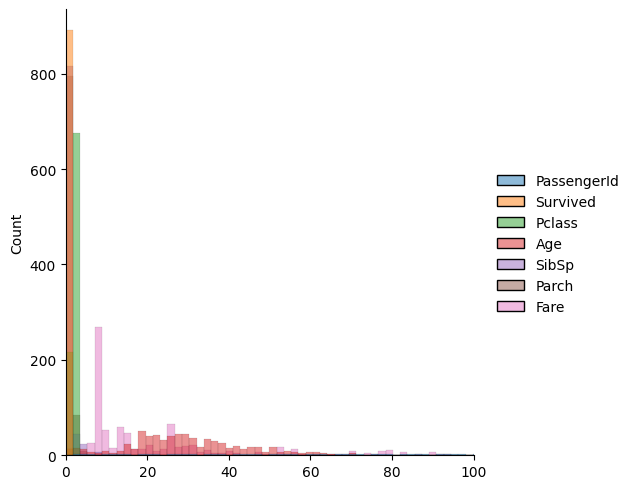

In [583]:
plt.figure(figsize=(15,15))
sns.displot(df00.select_dtypes('number'), bins=(500))
plt.xlim(0,100)

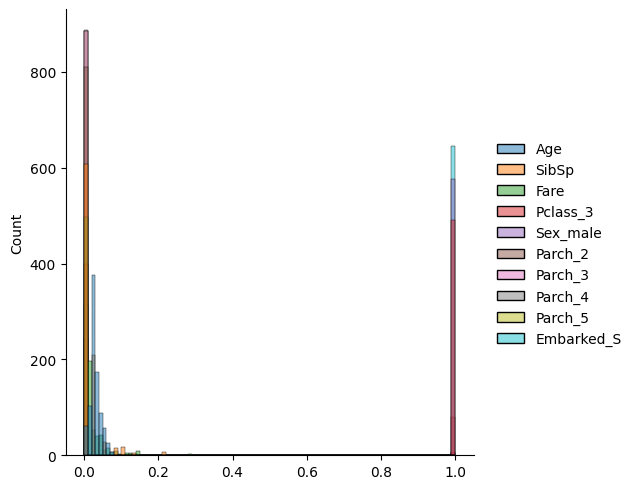

<Figure size 1500x1500 with 0 Axes>

In [584]:
sns.displot(df0.select_dtypes('number'), bins=(100))
plt.figure(figsize=(15,15))
plt.show()

<Axes: >

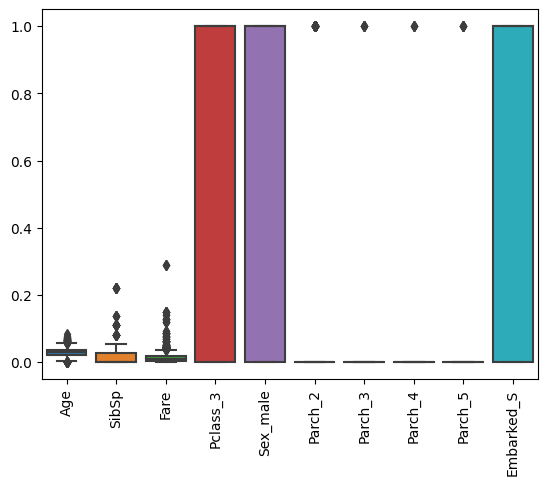

In [585]:
plt.xticks(rotation=90)
sns.boxplot(df0)

In [586]:
clf = LazyClassifier(verbose= -1, ignore_warnings = True, custom_metric = None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 12.51it/s]

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [587]:
pd.DataFrame(models)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.82,0.79,0.79,0.81,0.37
NuSVC,0.81,0.79,0.79,0.81,0.07
DecisionTreeClassifier,0.80,0.78,0.78,0.80,0.03
Perceptron,0.79,0.78,0.78,0.79,0.03
LinearSVC,0.80,0.78,0.78,0.80,0.10
LogisticRegression,0.80,0.78,0.78,0.80,0.03
CalibratedClassifierCV,0.80,0.78,0.78,0.80,0.27
KNeighborsClassifier,0.80,0.78,0.78,0.80,0.05
SVC,0.80,0.78,0.78,0.80,0.06


<Axes: >

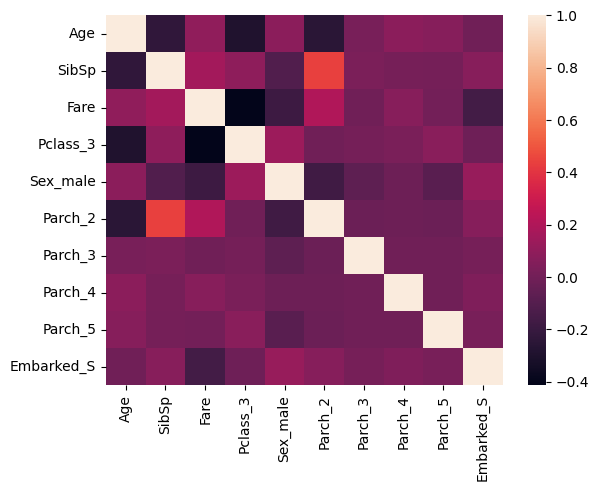

In [588]:
sns.heatmap(df0.corr())